In [115]:
import sys
sys.path.append('/kaggle/input/classes-realwaste')

In [116]:
from RealWaste import Preprocessor

preprocessor=Preprocessor('/kaggle/input/realwaste/realwaste-main/RealWaste')

train_ds,test_ds,classes=preprocessor.get_datasets()
print(f'Train size: {len(train_ds)}, Test size: {len(test_ds)}')

Train size: 3801, Test size: 951


In [117]:
from RealWaste import DataLoaderCreator

batch_size=32
dl_creator=DataLoaderCreator(train_ds,test_ds,batch_size)
train_dl,test_dl=dl_creator.get_dataloader()
print(f'Device being used: {dl_creator.device}')

Device being used: cuda


In [118]:
stats=preprocessor.stats
print(stats)

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


In [119]:
from RealWaste import EDA

In [120]:
eda=EDA(classes,stats)

Label:  Cardboard (0)


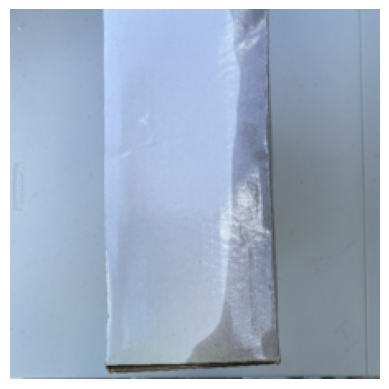

In [121]:
image,label=train_ds[20]
eda.show_image(image,label)

Label:  Textile Trash (7)


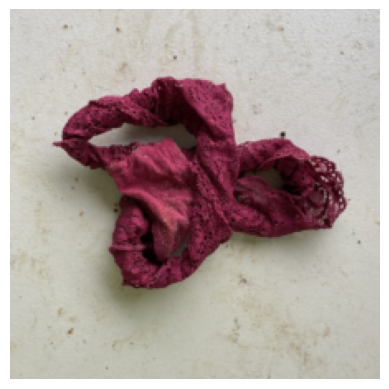

In [122]:
image,label=train_ds[200]
eda.show_image(image,label)

Label:  Plastic (6)


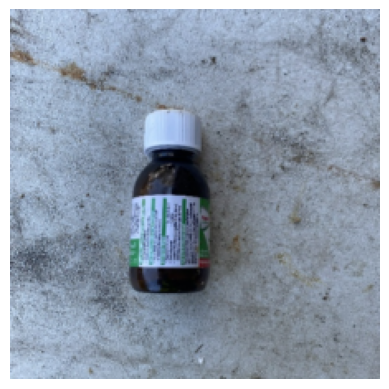

In [123]:
image,label=train_ds[2000]
eda.show_image(image,label)

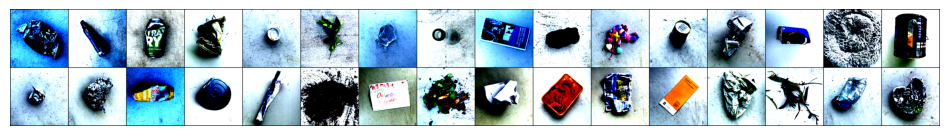

In [124]:
eda.show_batch(train_dl)

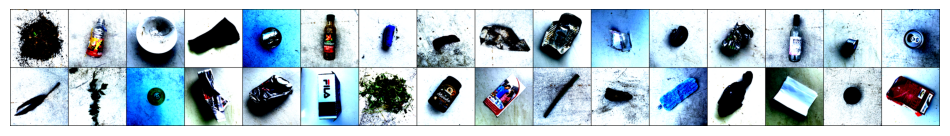

In [125]:
eda.show_batch(train_dl)

In [126]:
from RealWaste import ImageClassificationModel

In [127]:
import torch.nn as nn
from torchvision import models

class Model(ImageClassificationModel):
    def __init__(self, out_size):
        super().__init__()

        self.efficientnet = models.efficientnet_b0(weights='DEFAULT')

        num_features = self.efficientnet.classifier[-1].in_features
        
        self.efficientnet.classifier[-1] = nn.Linear(num_features, out_size)

    def forward(self, x):
        x = self.efficientnet(x)
        return x

In [128]:
model=Model(out_size=len(classes))
model=model.to('cuda')

In [129]:
import torch.optim as optim

max_lr=0.001
weight_decay=1e-4
epochs=15

In [130]:
import time
start=time.time()

history=model.fit(epochs=epochs,max_lr=max_lr,train_loader=train_dl,val_loader=test_dl,
                  weight_decay=weight_decay,grad_clip=0.1,
                 opt_func=optim.AdamW)

print(f'Training time: {(time.time()-start)/60} minutes')

Epoch [0], train_loss: 1.7141, train_acc: 0.4762, val_loss: 0.9000, val_acc: 0.7349
Epoch [1], train_loss: 0.6298, train_acc: 0.7896, val_loss: 0.3905, val_acc: 0.8656
Epoch [2], train_loss: 0.3772, train_acc: 0.8758, val_loss: 0.4566, val_acc: 0.8582
Epoch [3], train_loss: 0.3665, train_acc: 0.8829, val_loss: 0.6403, val_acc: 0.7978
Epoch [4], train_loss: 0.3062, train_acc: 0.8981, val_loss: 0.4595, val_acc: 0.8620
Epoch [5], train_loss: 0.1858, train_acc: 0.9408, val_loss: 0.5233, val_acc: 0.8500
Epoch [6], train_loss: 0.1448, train_acc: 0.9537, val_loss: 0.3897, val_acc: 0.8879
Epoch [7], train_loss: 0.1032, train_acc: 0.9664, val_loss: 0.3370, val_acc: 0.8962
Epoch [8], train_loss: 0.0450, train_acc: 0.9874, val_loss: 0.3403, val_acc: 0.9142
Epoch [9], train_loss: 0.0279, train_acc: 0.9916, val_loss: 0.2765, val_acc: 0.9299
Epoch [10], train_loss: 0.0127, train_acc: 0.9966, val_loss: 0.2739, val_acc: 0.9391
Epoch [11], train_loss: 0.0109, train_acc: 0.9968, val_loss: 0.2907, val_ac

In [131]:
from RealWaste import Evaluation

In [132]:
eval=Evaluation(model,'cuda')

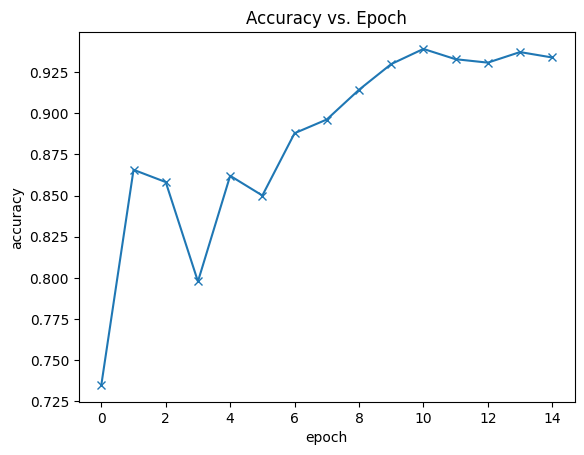

In [133]:
eval.plot_accuracies(history)

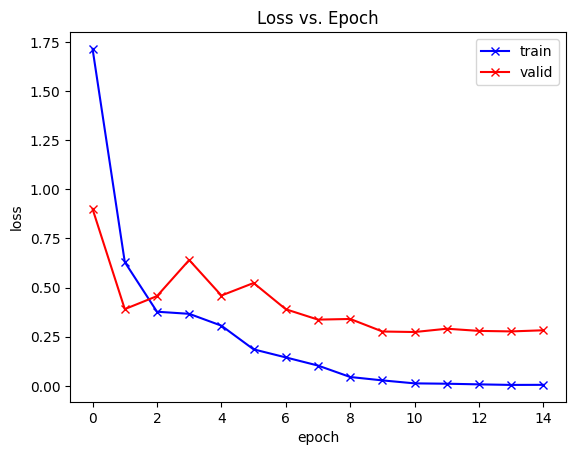

In [134]:
eval.plot_losses(history)

In [135]:
accuracy,f1,precision,recall=eval.evaluate(test_dl)
print(f'Test dataset metrics: ')
print(f'Accuracy: {accuracy*100}%')
print(f'F1 Score: {f1*100}%')
print(f'Precision Score: {precision*100}%')
print(f'Recall Score: {recall*100}%')

Test dataset metrics: 
Accuracy: 93.37539432176656%
F1 Score: 93.33573256024304%
Precision Score: 93.33042083204379%
Recall Score: 93.5807298088428%


In [152]:
import pandas as pd
import torch

def predict_images(model, test_loader, classes):
    model.eval()
    predictions = []
    actuals = []
    indices = []

    device = next(model.parameters()).device

    for idx, (img, label) in enumerate(test_loader):
        img = img.to(device)  

        with torch.no_grad():
            output = model(img)
            _, preds = torch.max(output, dim=1) 

        for i in range(preds.size(0)):
            predictions.append(classes[preds[i].item()])  
            actuals.append(classes[label[i].item()])  
            indices.append(idx * len(img) + i)  

    results_df = pd.DataFrame({
        'Index': indices,
        'Actual': actuals,
        'Predicted': predictions
    })

    return results_df

In [155]:
from sklearn.utils import shuffle
results_df=predict_images(model,test_dl,classes)

In [156]:
results_df=shuffle(results_df)

In [157]:
print(results_df.head(10))

     Index               Actual            Predicted
888    888                Paper                Paper
652    652  Miscellaneous Trash  Miscellaneous Trash
515    515              Plastic              Plastic
321    321                Glass                Glass
687    687                Metal                Metal
295    295        Textile Trash        Textile Trash
728    728  Miscellaneous Trash  Miscellaneous Trash
706    706           Vegetation           Vegetation
824    824           Vegetation           Vegetation
940    814                Glass                Glass


In [158]:
results_df=shuffle(results_df)

In [159]:
print(results_df.head(10))

     Index         Actual      Predicted
120    120      Cardboard      Cardboard
900    774  Food Organics  Food Organics
720    720      Cardboard      Cardboard
602    602          Metal          Metal
854    854  Food Organics  Food Organics
12      12     Vegetation     Vegetation
942    816        Plastic        Plastic
945    819          Glass          Glass
873    873        Plastic        Plastic
452    452     Vegetation     Vegetation
